В этом ноутбуке мы чуть более подробно познакомимся с идеями, лежащими в основе диффузионных моделей.

## Давайте начнем с конца и посмотрим, на что способна хорошо обученная диффузионная модель. Если модель не загружается, выполните закомментированные ячейки и получите токен на сайте [Huggingface](https://huggingface.co/join)

## 1. Выберите другую предобученную модель и сгенерируйте интересное изображение. 2 балла.
При выборе модели посмотрите инструкцию для ее использования, возможно, нужно будет изменить некоторые куски кода, например, pipe

In [ ]:
# %pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0
# %%capture
# !sudo apt -qq install git-lfs
# !git config --global credential.helper store

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
import torch
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from diffusers import DiffusionPipeline

# Можно провести обзор https://huggingface.co/sd-dreambooth-library для использования множества других моделей
model_id = "stabilityai/stable-diffusion-xl-base-1.0" # учтите, что модель должна быть Text2Image

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2%2Fconfig.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2%2Ftokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

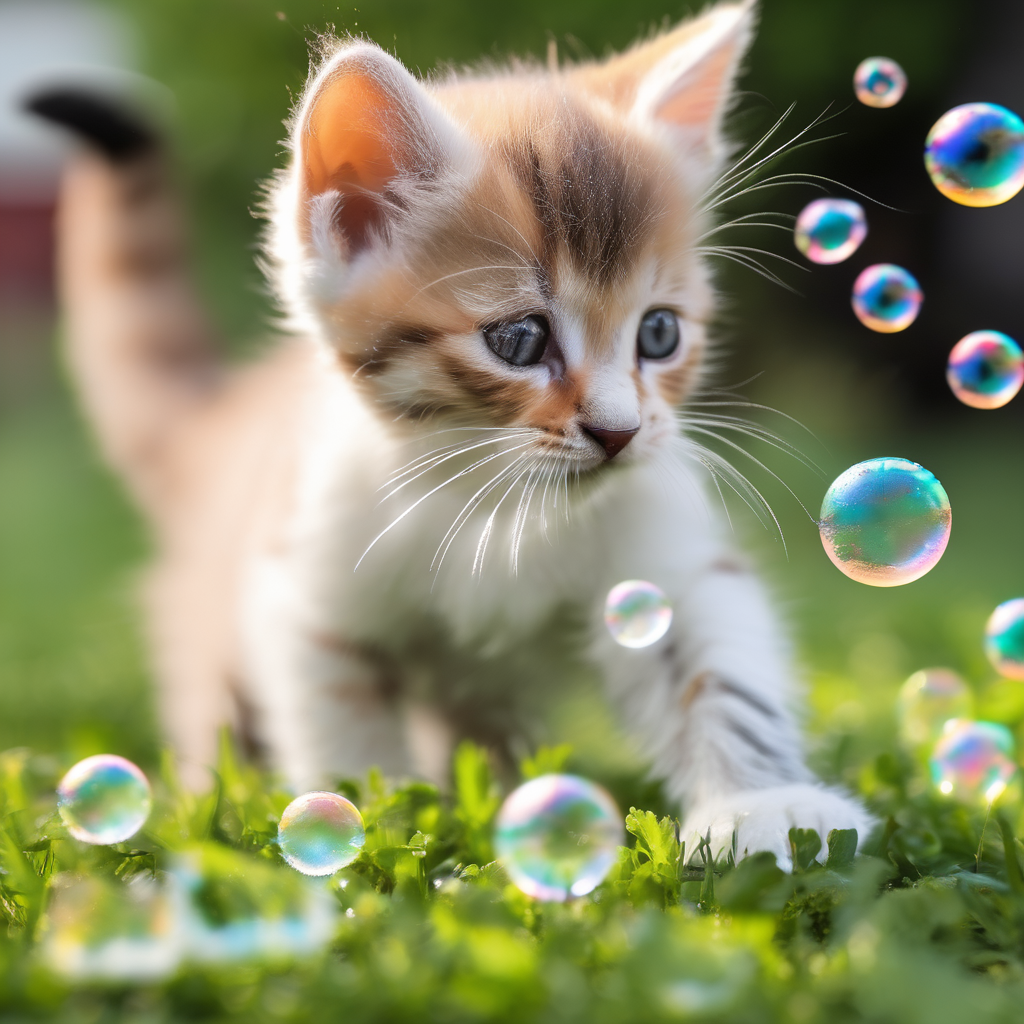

In [ ]:
prompt = "Kitten is playing with soap bubbles in the yard"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

In [ ]:
image.save("example.png")

## 2. Добавление шума. Напишите код для прямого процесса в диффузионной модели. 3 балла

In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Функция для визуализации процесса
def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Step {i*25}")
    plt.suptitle(title)
    plt.show()

In [ ]:
# Загружаем и подготавливаем изображение
image_path = "example.png"  # Укажите путь к изображению
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)  # (1, C, H, W)

In [ ]:
# Параметры шума
timesteps = 201  # Общее количество шагов
save_steps = 25  # Интервал сохранения картинок
beta = torch.linspace(0.0001, 0.02, timesteps)  # Линейное расписание beta
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)  # Кумулятивное произведение

In [ ]:
# Итерационный метод
noisy_images_iter = []
current_image = image_tensor.clone()

for t in range(0, timesteps):
    noise = torch.randn_like(current_image)  # Случайный шум
    current_image = current_image*np.sqrt(alpha[t]) + noise*np.sqrt(beta[t])

    current_image = torch.clip(current_image, 0.0, 1.0)
    if t % save_steps == 0:
        noisy_images_iter.append(current_image.squeeze().permute(1, 2, 0).numpy())

In [ ]:
(torch.randn_like(image_tensor)*np.sqrt(beta[0])).shape

torch.Size([1, 3, 512, 512])

In [ ]:
(torch.from_numpy(noisy_images_iter[0])*np.sqrt(alpha[0])).permute(2, 1, 0)

tensor([[[0.5365, 0.5282, 0.5353,  ..., 0.1975, 0.2365, 0.2457],
         [0.4954, 0.5366, 0.5297,  ..., 0.2321, 0.2220, 0.2505],
         [0.5448, 0.5341, 0.5576,  ..., 0.2187, 0.2464, 0.2555],
         ...,
         [0.1306, 0.1084, 0.1280,  ..., 0.3733, 0.3601, 0.3585],
         [0.1243, 0.1334, 0.1263,  ..., 0.3658, 0.3749, 0.3650],
         [0.1288, 0.1453, 0.1234,  ..., 0.3816, 0.3863, 0.3684]],

        [[0.5563, 0.5711, 0.5906,  ..., 0.2885, 0.3123, 0.3242],
         [0.5593, 0.5775, 0.5619,  ..., 0.3140, 0.3050, 0.3100],
         [0.5505, 0.5773, 0.5760,  ..., 0.3138, 0.3172, 0.3492],
         ...,
         [0.1143, 0.1118, 0.1206,  ..., 0.4644, 0.4649, 0.4709],
         [0.1250, 0.1405, 0.1351,  ..., 0.4766, 0.4797, 0.4829],
         [0.1191, 0.1185, 0.1338,  ..., 0.4923, 0.4843, 0.4868]],

        [[0.5573, 0.5619, 0.5668,  ..., 0.1314, 0.1645, 0.1707],
         [0.5532, 0.5850, 0.5864,  ..., 0.1586, 0.1665, 0.1730],
         [0.5471, 0.5706, 0.6005,  ..., 0.1627, 0.1663, 0.

In [ ]:
# Формульный метод (добавление шума с 0 шага сразу на произвольный t-й шаг)
noisy_images_formula = []
for t in range(0, timesteps, save_steps):
    noise = torch.randn_like(image_tensor)
    noisy_image = (torch.from_numpy(noisy_images_iter[t//save_steps])*np.sqrt(alpha[t])).permute(2, 0, 1) + (noise*np.sqrt(beta[t]))


    noisy_image = torch.clip(noisy_image, 0.0, 1.0)
    noisy_images_formula.append(noisy_image.squeeze().permute(1, 2, 0).numpy())

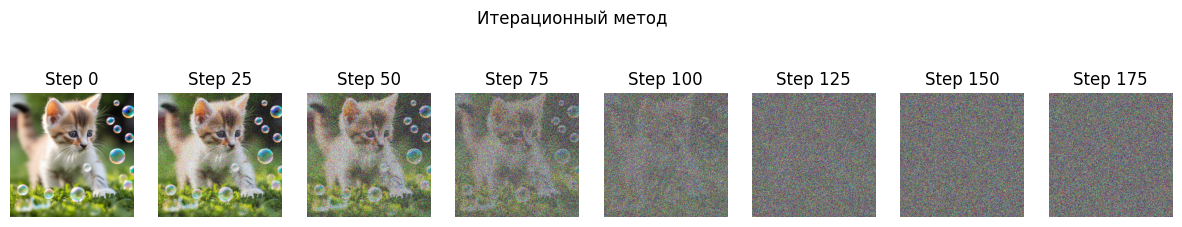

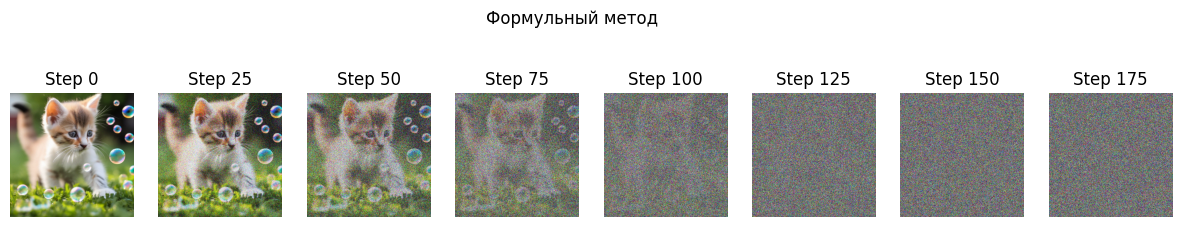

In [ ]:
# Визуализируем результаты
show_images(noisy_images_iter, "Итерационный метод")
show_images(noisy_images_formula, "Формульный метод")

# Какая-то магия...

## 3. Что такое диффузионные модели? Запустите код и напишите выводы. В этом задании не нужно писать код, просто запустите и проанализируйте, что происходит. 3 балла



 Модель диффузии (снижения уровня шума) не так уж сложна, если сравнить ее с другими генерирующими моделями, такими как нормализующие потоки, GAN или VAE: все они преобразуют шум из некоторого простого распределения в выборку данных. Хоть это также тот случай, когда нейронная сеть учится постепенно устранять помехи в данных, начиная с чистого шума.

Если говорить более подробно о изображениях, то модель состоит из 2 процессов:
* Установленный нами фиксированный процесс прямого зашумления $q$, который постепенно добавляет гауссовский шум к изображению, пока в итоге вы не получите чистый шум
* Обратный процесс рассеивания шума $p_\theta$, при котором нейронная сеть обучается постепенно устранять шумы на изображении, начиная с чистого шума, пока в итоге мы не получим реальное изображение.

<p align="center">
    <img src="https://drive.google.com/uc?id=1t5dUyJwgy2ZpDAqHXw7GhUAp2FE5BWHA" width="600" />
</p>

Как прямой, так и обратный процессы с индексом \\(t\\), выполняются за некоторое количество конечных временных шагов \\(T\\) (авторы статьи Denoising Diffusion Probabilistic Models (далее DDPM) используют \\(T=1000\\)). Вы начинаете с \\(t = 0\\), где вы выбираете изображение \\(\mathbf {x}_0\\) из вашего распределения данных (допустим, изображение собаки из ImageNet), прямой процесс сэмплирует некоторый шум из гауссовского распределения на каждом этапе в каждый временной шаг \\(t\\), который добавляется к изображению предыдущего временного шага. При достаточно большом значении \\(T\\) изображение превращается в гауссовский шум.

#### Где же тут нейронная сеть

Нейронная сеть должна получать зашумленное изображение на определенном временном шаге и возвращать прогнозируемый шум, который был добавлен на прошлом шаге (только на прошлом, а не сумму всех шумов, добавленных до этого шага). Обратите внимание, что прогнозируемый шум - это тензор, который имеет ту же форму, что и входное изображение. Таким образом, технически сеть принимает и выдает тензоры одинаковой формы. Какой тип нейронной сети мы можем использовать для этого?

То, что обычно используется для прогнозирования шума (чтобы потом очистить от него), очень похоже на [Автоэнкодер](https://en.wikipedia.org/wiki/Autoencoder). У автоэнкодеров есть так называемое "узкое место" между кодировщиком и декодером. Сначала кодировщик преобразует изображение в меньшее скрытое представление(на данной картинке в вектор длины 1024), называемое "узким горлышком" (ориг. bottleneck), а затем декодер преобразует это скрытое представление обратно в изображение. Это вынуждает сеть сохранять только самую важную информацию на уровне узких мест.

 Авторы DDPM выбрали U-Net, представленный в [Роннебергер и др., 2015](https://arxiv.org/abs/1505.04597 ) (который в то время достиг самых современных результатов в сегментации медицинских изображений). Эта сеть, как и любой автоэнкодер, состоит из узкого места посередине, которое гарантирует, что сеть узнает только самую важную информацию. Важно отметить, что в нем были введены остаточные соединения между кодировщиком и декодером, что значительно улучшило градиентный поток (вдохновились ResNet в [He et al., 2015](https://arxiv.org/abs/1512.03385)).

<p align="center">
    <img src="https://drive.google.com/uc?id=1_Hej_VTgdUWGsxxIuyZACCGjpbCGIUi6" width="800" />
</p>




### Сеть можно контролировать, чтобы генерировать не случайное изображение, а то, что мы напишем в prompt (то, что вы делали в начале тетрадки). Тогда во время обучения надо тоже подавать в сеть промпты, иначе она не научится связывать описание и картинку.


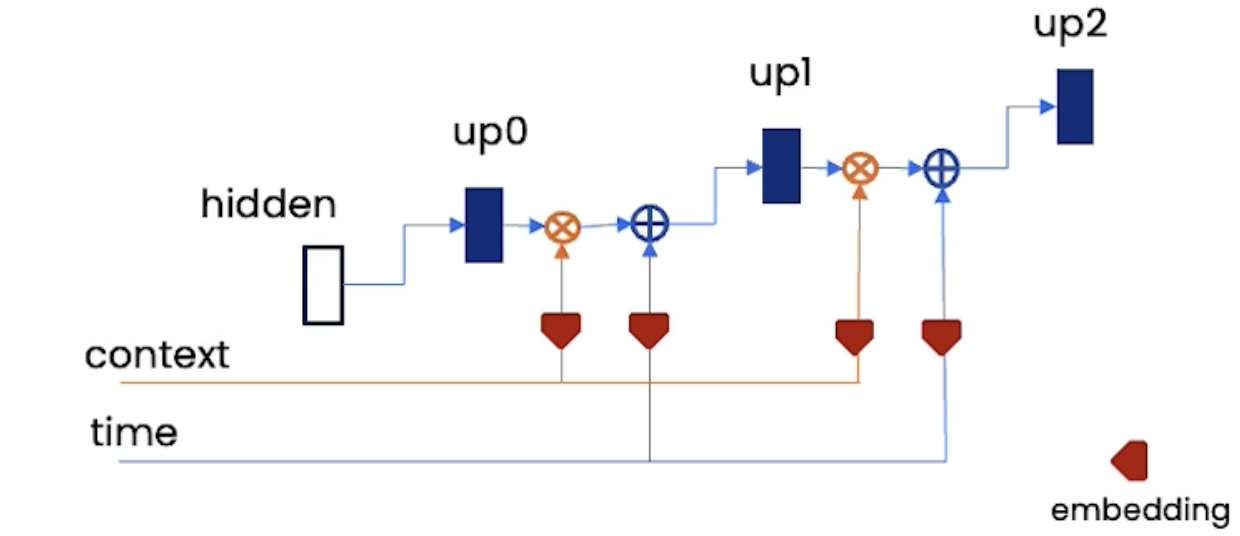

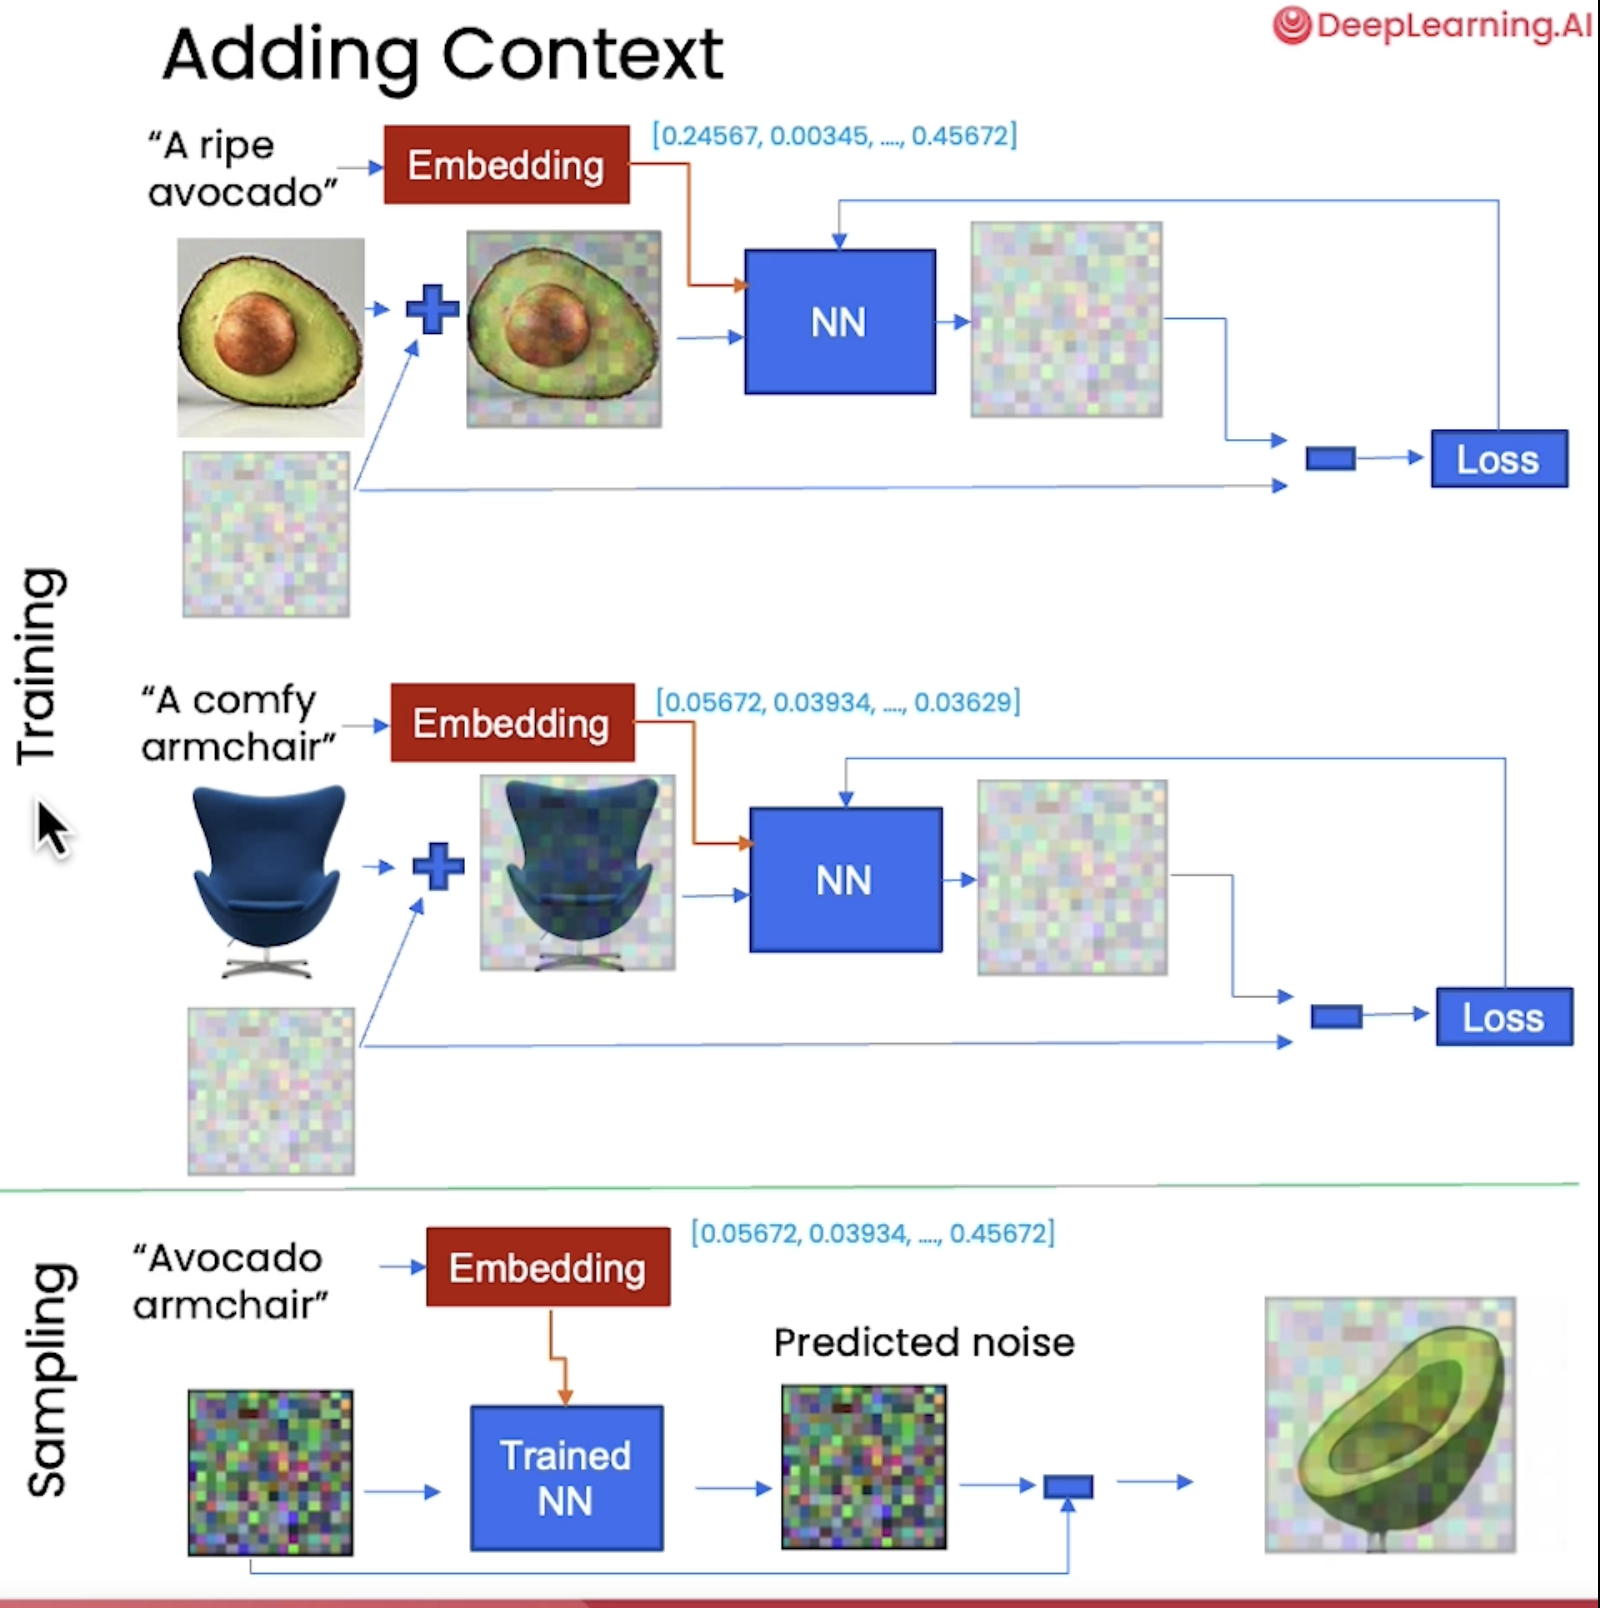

### Setup

In [1]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

import torch
from torch import nn, einsum
import torch.nn.functional as F

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.7 MB/s eta 0:00:00


### Определение нейронной сети. Просто выполните код в ячейках, не нужно разбираться, что тут написано.

In [2]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [4]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [5]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [6]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [7]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,

    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)


        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [8]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [9]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

### Объявление $\beta_t$ и $\alpha_t$

In [10]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [11]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

### Здесь мы определяем обычный [PyTorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Датасет может состоять из изображений из реального набора данных, такого как MNIST, CIFAR-10 или ImageNet

In [12]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("mnist")
image_size = 28
channels = 1
batch_size = 128

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

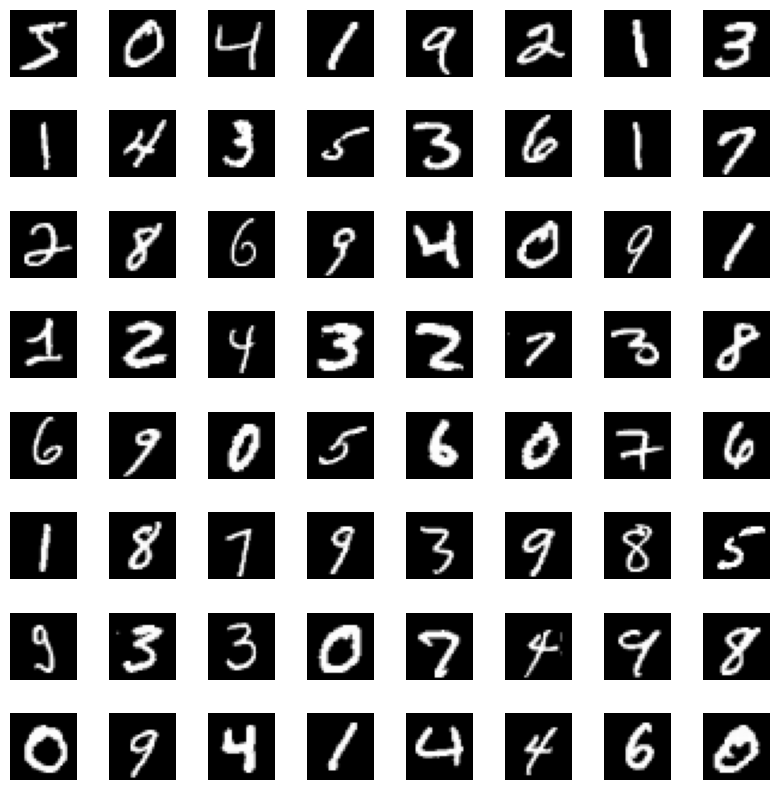

In [13]:
import matplotlib.pyplot as plt

# Посмотрим, из чего состоит датасет
# Для этого выберем первые 64 объекта и нарисуем сетку 8x8
sample_images = dataset['train']['image'][:64]

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

for i in range(8):
    for j in range(8):
        ax = axes[i, j]
        ax.imshow(sample_images[i * 8 + j], cmap='gray')
        ax.axis('off')

plt.show()

In [14]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))

In [15]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [16]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [17]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [18]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

Epoch [1/10], Step [0/469], Loss: 0.4574
Epoch [1/10], Step [100/469], Loss: 0.1272
Epoch [1/10], Step [200/469], Loss: 0.0574
Epoch [1/10], Step [300/469], Loss: 0.0494
Epoch [1/10], Step [400/469], Loss: 0.0453
Epoch [2/10], Step [0/469], Loss: 0.0418
Epoch [2/10], Step [100/469], Loss: 0.0422
Epoch [2/10], Step [200/469], Loss: 0.0350
Epoch [2/10], Step [300/469], Loss: 0.0364
Epoch [2/10], Step [400/469], Loss: 0.0343
Epoch [3/10], Step [0/469], Loss: 0.0303
Epoch [3/10], Step [100/469], Loss: 0.0558
Epoch [3/10], Step [200/469], Loss: 0.0284
Epoch [3/10], Step [300/469], Loss: 0.0295
Epoch [3/10], Step [400/469], Loss: 0.0272
Epoch [4/10], Step [0/469], Loss: 0.0303
Epoch [4/10], Step [100/469], Loss: 0.0306
Epoch [4/10], Step [200/469], Loss: 0.0258
Epoch [4/10], Step [300/469], Loss: 0.0352
Epoch [4/10], Step [400/469], Loss: 0.0292
Epoch [5/10], Step [0/469], Loss: 0.0259
Epoch [5/10], Step [100/469], Loss: 0.0236
Epoch [5/10], Step [200/469], Loss: 0.0272
Epoch [5/10], Step [3

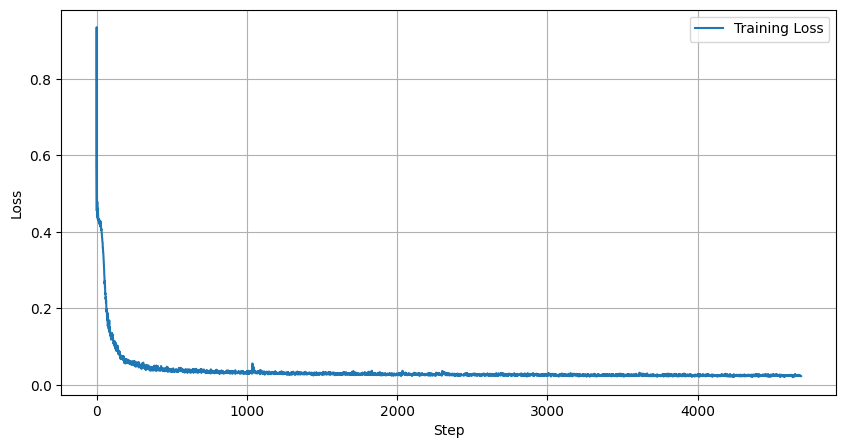

In [19]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty list to store the loss values
loss_values = []

epochs = 10

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, batch, t, loss_type="huber")

        if step % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                epoch + 1, epochs, step, len(dataloader), loss.item()))

        # Append the loss value to the list
        loss_values.append(loss.item())

        loss.backward()
        optimizer.step()



# After training, plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(loss_values)), loss_values, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
torch.save(model.state_dict(), "diff.pt")

In [21]:
model.load_state_dict(torch.load("diff.pt", weights_only=True, map_location=device))
model.eval()
print()

In [22]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

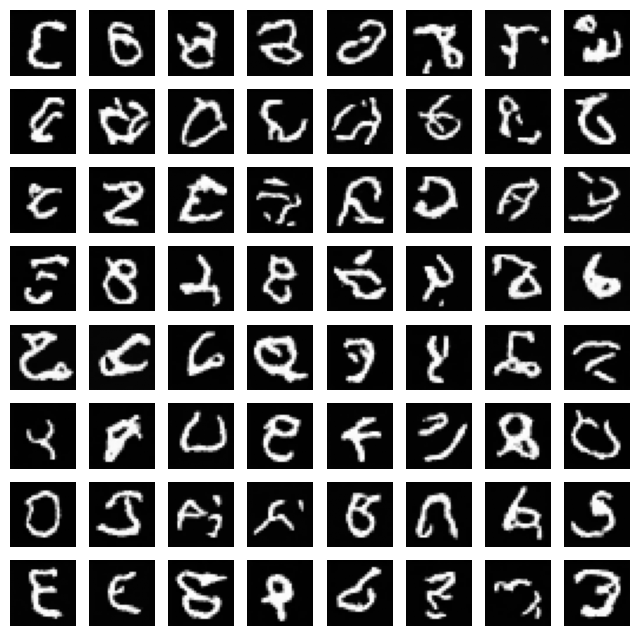

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Define the size of the grid
rows, cols = 8, 8

# Create a figure and axis for subplots
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

for i in range(rows):
    for j in range(cols):
        # Plot each element using imshow
        index = (i * cols + j)

        axes[i, j].imshow(samples[-1][index].reshape(image_size, image_size, channels), cmap="gray")
        axes[i, j].axis('off')  # Turn off axis labels and ticks

# Show the plot
plt.show()

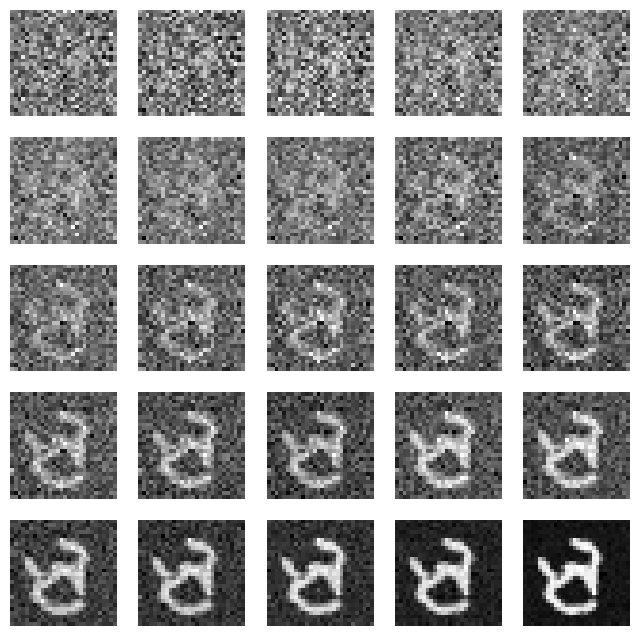

In [96]:
import matplotlib.pyplot as plt
import numpy as np
generated_index=2

# Define the size of the grid
rows, cols = 5, 5

# Create a figure and axis for subplots
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))


for i in range(rows):
    for j in range(cols):
        # Plot each element using imshow
        index = (i * cols + j)*8

        axes[i, j].imshow(samples[index][generated_index].reshape(image_size, image_size, channels), cmap="gray")
        axes[i, j].axis('off')  # Turn off axis labels and ticks



# Show the plot
plt.show()

## Вывод нужно сделать только по результатам следующего кода.

In [43]:
check_img = next(iter(dataloader))
check_img = check_img["pixel_values"]
check_img = check_img[2][None, :, :, :]

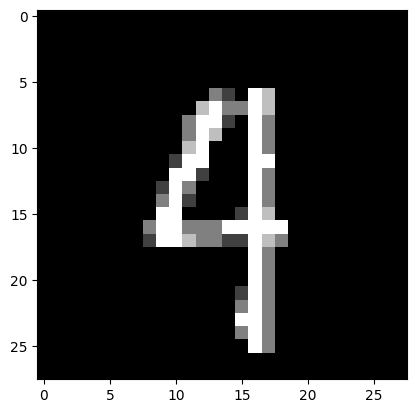

In [44]:
plt.imshow(check_img.reshape(image_size, image_size, channels), cmap="gray")

In [86]:
noise = torch.randn_like(check_img)

x_noisy = q_sample(x_start=check_img, t=torch.tensor([1]), noise=noise)

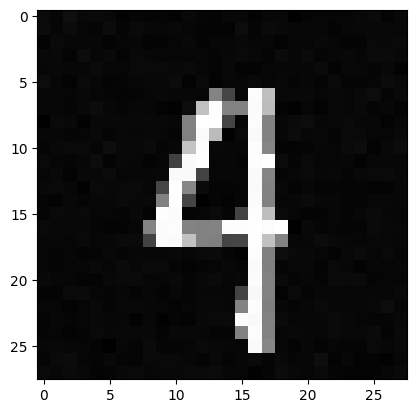

In [87]:
plt.imshow((x_noisy).detach().numpy().reshape(image_size, image_size, channels), cmap="gray")

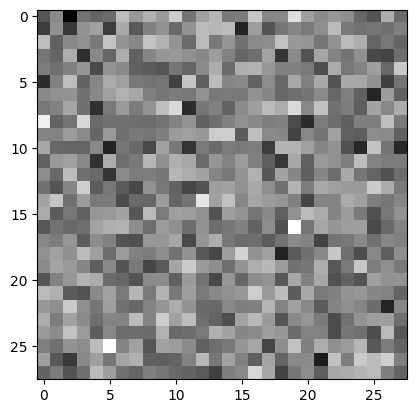

In [88]:
plt.imshow((check_img - x_noisy).detach().numpy().reshape(image_size, image_size, channels), cmap="gray")

In [89]:
res = model(x_noisy.to(device), torch.tensor([1]).to(device))

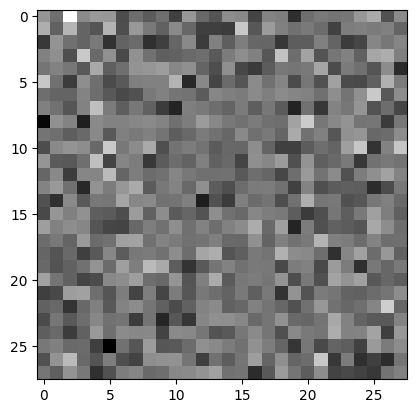

In [90]:
plt.imshow(res.cpu().detach().numpy().reshape(image_size, image_size, channels), cmap="gray")

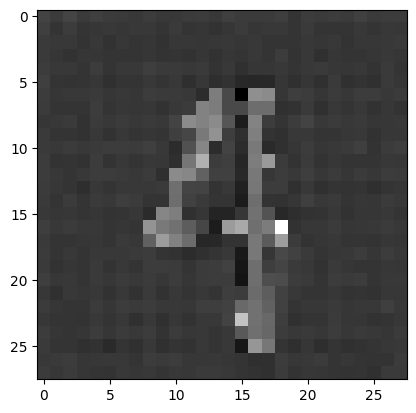

In [95]:
res = model(x_noisy.to(device), torch.tensor([100]).to(device))
plt.imshow(res.cpu().detach().numpy().reshape(image_size, image_size, channels), cmap="gray")

# Ваш вывод ...

В приведённом коде мы можем поэтапно отследить основные идеи и этапы работы диффузионных моделей, а именно:
1.   На первой картинке видим исходное изображение, с которым будет проводиться манипуляция. Мы будем постепенно накладывать шум, можно сказать слоями, на это изображение.
2.   Вторая картинка показывает нам результат наложения первого слоя шума на картинку. На этом этапе черты исходного изображения легко узнаются, хотя и разница между ними значительна и очевидна.
3. Третья картинка является разностью первых двух и показывает нам характер наложенного шума. Именно от этих пикселей модель учится минимизировать расстояние. То есть смотрит такую же разность, но между своим предсказанием того, какой шум был наложен на исходную картинку, и нашей третьей картинкой.
4. На четвертой же изображена попытка модели восстановить исходную картинку по зашумленной с временным шагом равным 1. Но так как результат совсем не очевиден, был добавлен ещё один блок кода, использующий временной шаг в 100, благодаря чему можно увидеть очертания исходного изображения и сделать вывод, что модель идёт в верном направлении.

В общем и целом, это хорошая демонстрация принципа работы диффузионных моделей даже для людей, далёких от математики и программирования, ведь поэтапно видно, как изображение “загрязняется” и на небольших шагах невооруженным взглядом можно понять, как “очистить” картинку до исходного состояния. Грубо говоря, модель обучается делать то же самое, но настолько хорошо и на таком большом количестве шагов, что по итогу учится генерировать что-то новое из практически равномерного шума.


# 4. Докажите формулу из лекции. 2 балла

<p align="center">
    <img src="https://drive.google.com/uc?id=1IdYxVZ-Lgy7pIk_pNj3-xwzdWABAY6Ie" width="600" />
</p>

### Прикрепите фотографию с доказательством ниже, либо пришлите ее в сообщении вместе с ноутбуком

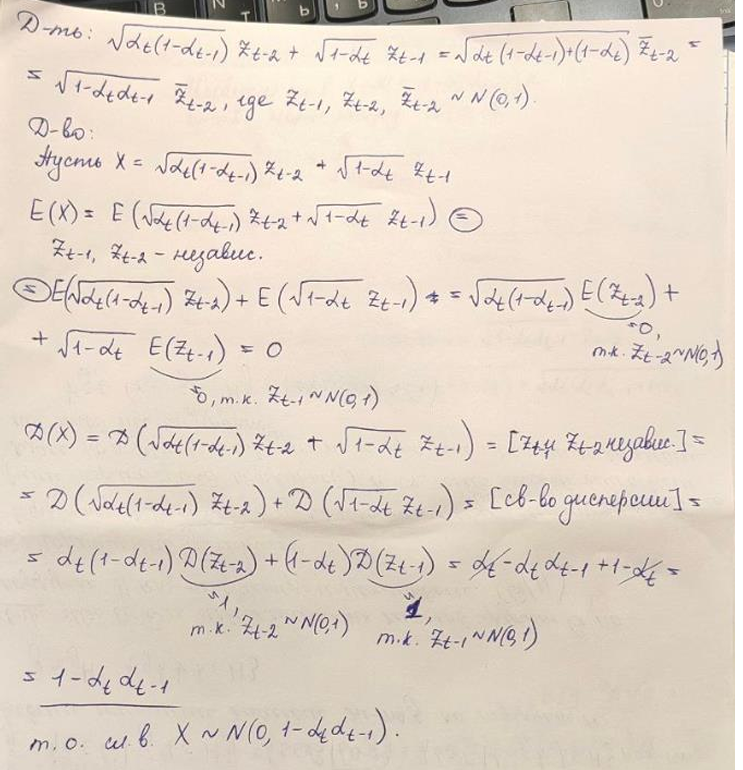

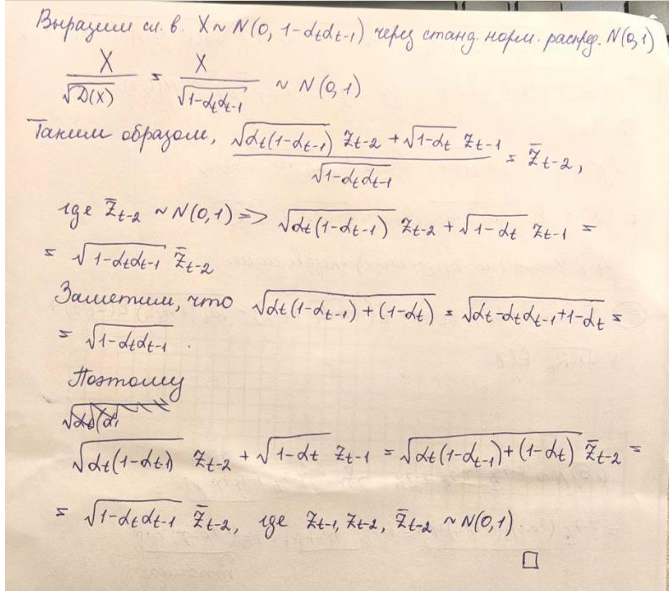